In [16]:
import os                
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
 
from PIL import Image
from pathlib import Path
from PIL import ImageFile
from torchvision import datasets
 
batch_size = 128
IMAGE_SIZE = 224
 
MEANS = [0.485, 0.456, 0.406]
DEVIATIONS = [0.229, 0.224, 0.225]

In [17]:
train_transform = transforms.Compose([transforms.RandomRotation(30), # 이미지를 랜덤으로 30도 각도로 회전
                                      transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.08, 1.0), ratio=(0.75, 1.33)), # 이미지 사이즈 변경
                                      transforms.RandomHorizontalFlip(), # 이미지를 수평으로 뒤집는다
                                      transforms.ToTensor(), # 데이터 타입을 Tensor 형태로 변경
                                      transforms.Normalize(MEANS, DEVIATIONS) # 데이터 정규화
                                      ])
 
test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), # IMAGE_SIZE로 이미지 사이즈 변경
                                      transforms.CenterCrop(IMAGE_SIZE), # 이미지를 square하게 변경
                                      transforms.ToTensor(), # 데이터 타입을 Tensor 형태로 변경
                                      transforms.Normalize(MEANS, DEVIATIONS) # 데이터 정규화
                                      ])
 

In [18]:
from torchvision.datasets import ImageFolder

training = datasets.ImageFolder("./train", transform=train_transform) # ImageFolder를 사용해 dataset 생성
testing = datasets.ImageFolder("./test", transform=test_transform) # ImageFolder를 사용해 dataset 생성

train_batches = torch.utils.data.DataLoader(training, batch_size=batch_size, shuffle=True) # train_loader 생성
test_batches = torch.utils.data.DataLoader(testing, batch_size=batch_size) # test 데이터는 batch사이즈 맞춰 그대로

In [19]:
model_transfer = models.densenet161(pretrained=True).cuda()

In [21]:
for param in model_transfer.parameters():
  param.requires_grad = False # requires_grad를 사용해 parameter 동결
 
model_transfer.classifier = nn.Linear(model_transfer.classifier.in_features, 5) # 마지막 layer을 BREEDS개의 class로 분류하도록 재정의
# 이 때, requires_grad 옵션은 True
 
nn.init.kaiming_normal_(model_transfer.classifier.weight, nonlinearity='relu') # 재정의한 layer의 weight를 initialize
 
print(model_transfer.classifier)

Linear(in_features=2208, out_features=5, bias=True)


Epoch: 1 	Training Loss: 1.2555
Train loss decreased inf --> 1.2555. Saving model ...
Epoch: 2 	Training Loss: 1.0105
Train loss decreased 1.2555 --> 1.0105. Saving model ...
Epoch: 3 	Training Loss: 0.9360
Train loss decreased 1.0105 --> 0.9360. Saving model ...
Epoch: 4 	Training Loss: 0.9024
Train loss decreased 0.9360 --> 0.9024. Saving model ...
Epoch: 5 	Training Loss: 0.8910
Train loss decreased 0.9024 --> 0.8910. Saving model ...
Epoch: 6 	Training Loss: 0.8568
Train loss decreased 0.8910 --> 0.8568. Saving model ...
Epoch: 7 	Training Loss: 0.8582
Epoch: 8 	Training Loss: 0.8328
Train loss decreased 0.8568 --> 0.8328. Saving model ...
Epoch: 9 	Training Loss: 0.8491
Epoch: 10 	Training Loss: 0.8236
Train loss decreased 0.8328 --> 0.8236. Saving model ...
Epoch: 11 	Training Loss: 0.8077
Train loss decreased 0.8236 --> 0.8077. Saving model ...
Epoch: 12 	Training Loss: 0.8218
Epoch: 13 	Training Loss: 0.8154
Epoch: 14 	Training Loss: 0.7998
Train loss decreased 0.8077 --> 0.799

FileNotFoundError: [Errno 2] No such file or directory: 'myimg'

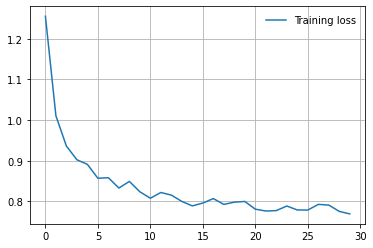

In [22]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_transfer = model_transfer.cuda()
 
criterion_transfer = nn.CrossEntropyLoss() 
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001, betas=[0.9, 0.999])
 
def train(n_epochs, train_loader, model, optimizer, criterion, use_cuda):  
    train_losses = []
    train_loss_min = np.Inf
 
    for epoch in range(1, n_epochs+1): # epoch만큼 반복
        # traing_loss와 valid_loss를 저장하기 위한 변수 선언
        train_loss = 0.0
 
        model.train() # 모델 training 
        for data, target in train_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda() # gpu에서 연산을 수행하기 위해
 
            optimizer.zero_grad() # 모든 model의 gradient 값을 0으로 설정
            output = model(data) # 모델을 forward pass해 결과값 저장 
            loss = criterion(output, target) # output과 target의 loss 계산
            loss.backward() # backward 함수를 호출해 gradient 계산
            optimizer.step() # 모델의 학습 파라미터 갱신
            train_loss += loss.item() * data.size(0) # loss값을 train에 더함 (나중에 loss의 평균을 구하기 위해 data.size를 곱함)
        
        train_loss = train_loss/len(train_loader.dataset) # 전체 train loader의 크기로 나눔
        train_losses.append(train_loss) # 결과를 plot할때 사용하기 위해 list에 값을 append
        
        print('Epoch: {} \tTraining Loss: {:.4f}'.format(
            epoch, train_loss))     
        
        if train_loss <= train_loss_min: # 더 좋은 결과가 나온 경우
            print('Train loss decreased {:.4f} --> {:.4f}. Saving model ...'.format(train_loss_min, train_loss))
            torch.save(model.state_dict(), 'model_transfer.pth')
            train_loss_min = train_loss # 최저 loss를 갱신함
        
    return model, train_losses

from PIL import ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

epochs = 30
 
model_transfer, train_losses = train(epochs, train_batches, model_transfer, optimizer_transfer, criterion_transfer, use_cuda)
 
model_transfer.load_state_dict((torch.load('model_transfer.pth'))) # test결과가 가장 좋았던 model을 불러와 저장

# loss값 그래프 출력
plt.plot(train_losses, label="Training loss")
plt.legend(frameon=False)
plt.grid(True)
 
def test(test_loader, model, criterion, use_cuda):
    class_correct = 0.
    class_total = 0.
    test_loss = 0.
 
    model.eval()
    for data, target in test_loader:
        if use_cuda:
          data, target = data.cuda(), target.cuda()
        output = model(data)  # 모델을 forward pass해 결과값 저장 
        loss = criterion(output, target) # output과 target의 loss 계산
        test_loss += loss.item() * data.size(0) # loss값을 test_loss에 더함 
        _, pred = torch.max(output, 1) # 출력이 분류 각각에 대한 값으로 나타나기 때문에, 가장 높은 값을 갖는 인덱스를 추출
        correct_tensor = pred.eq(target.data.view_as(pred)) # pred.eq를 사용해서 예측값과 실제값이 같은지 비교
         # gpu tensor는 numpy로 계산할 수 없기 때문에, 조건문을 사용해 cpu에서 계산되도록 함
        class_correct += np.sum(np.squeeze(correct_tensor.numpy())) if not use_cuda else np.sum(np.squeeze(correct_tensor.cpu().numpy()))
        class_total += data.size(0) # 전체 클래스 개수 
 
    test_loss = test_loss/len(test_loader.dataset) # test loss의 평균 계산
 
    # 결과 출력
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * class_correct / class_total, class_correct, class_total))
 
test(test_batches, model_transfer, criterion_transfer, use_cuda) # test메소드 사용
 
class_names = [item[0:].replace("_", " ") for item in train_batches.dataset.classes] # class 목록 list를 저장
 
train_batches.dataset.classes[:6] # class 목록 출력
 
def image_loader(img_path, transform, use_cuda):
    image = Image.open(img_path).convert('RGB')
    img = transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    return img
 
def predict_food_transfer(model, class_names, img_path):
    logit = model_transfer(image_loader(img_path, test_transform, True))
    idx = torch.max(logit,1)[1].item()
 
    return class_names[idx]
 
dirs = os.listdir('myimg')
 
for img_file in dirs:
    img_path = os.path.join('myimg', img_file)
    predition = predict_food_transfer(model_transfer, class_names, img_path)    
    print("image_file_name = {0}, \t predition food: {1}" .format(img_path, predition))
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.show()


In [23]:
test(test_batches, model_transfer, criterion_transfer, use_cuda) # test메소드 사용
 
class_names = [item[0:].replace("_", " ") for item in train_batches.dataset.classes] # class 목록 list를 저장
 
train_batches.dataset.classes[:5] # class 목록 출력
 
def image_loader(img_path, transform, use_cuda):
    image = Image.open(img_path).convert('RGB')
    img = transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    return img
 
def predict_food_transfer(model, class_names, img_path):
    logit = model_transfer(image_loader(img_path, test_transform, True))
    idx = torch.max(logit,1)[1].item()
 
    return class_names[idx]
 
dirs = os.listdir('image')
 
for img_file in dirs:
    img_path = os.path.join('image', img_file)
    predition = predict_food_transfer(model_transfer, class_names, img_path)    
    print("image_file_name = {0}, \t predition: {1}" .format(img_path, predition))
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    plt.show()


Test Loss: 0.805882


Test Accuracy: 67% (1538/2270)


FileNotFoundError: [Errno 2] No such file or directory: 'image'